## EDA of Nino3all

1. Load the Data
2. Basic Summary
3. Visual Inspection
- A line plot to see the trend of the temperature over the years.
- A histogram to understand the distribution of temperature values.
- A box plot to identify any outliers.
4. Seasonality and Stationarity Analysis
5. Missing Values
6. ACF and PACF plots
7. Finding optimal embedding parameters and TDE plot

In [13]:
#Libraries
import pandas as pd
import numpy as np
import time, os
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from nolitsa import dimension, delay
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("tab10")

In [17]:
# Reading the CSV file
dn = pd.read_csv("nino3all.csv", delimiter=",", 
                 names=["Year", "SST", "u1", "u2"], 
                 dtype={"Year": int, "SST": float})\
    .set_index("Year").loc[:,["SST"]]

dn.head()

,SST
Year,
500,-0.282936
501,-0.311611
502,-0.352213
503,-0.394318
504,-0.427186


### SUMMARY

In [3]:
# Summary of the 'SST' column
dn['SST'].describe()

count    1507.000000
mean       -0.434149
std         0.273249
min        -1.187971
25%        -0.609776
50%        -0.431610
75%        -0.283514
max         0.668219
Name: SST, dtype: float64

Summary of the "temp" column:

- Count: There are 1507 observations.
- Mean: The average temperature is approximately −0.434.
- Standard Deviation: The standard deviation is approximately 0.273, indicating the spread of the data.
- Minimum: The minimum temperature value is −1.188.
- Maximum: The maximum temperature value is 0.668.
- Quartiles: The 25th, 50th, and 75th percentiles are −0.610, −0.432, and −0.284, respectively.

### FIRST VISUAL INSPECTION

Let's plot the time series, histogram, and box-plot to get a better understanding of the trend, distribution, and any potential outliers. We'll start with a ts plot to see the trend of temperature over the years.

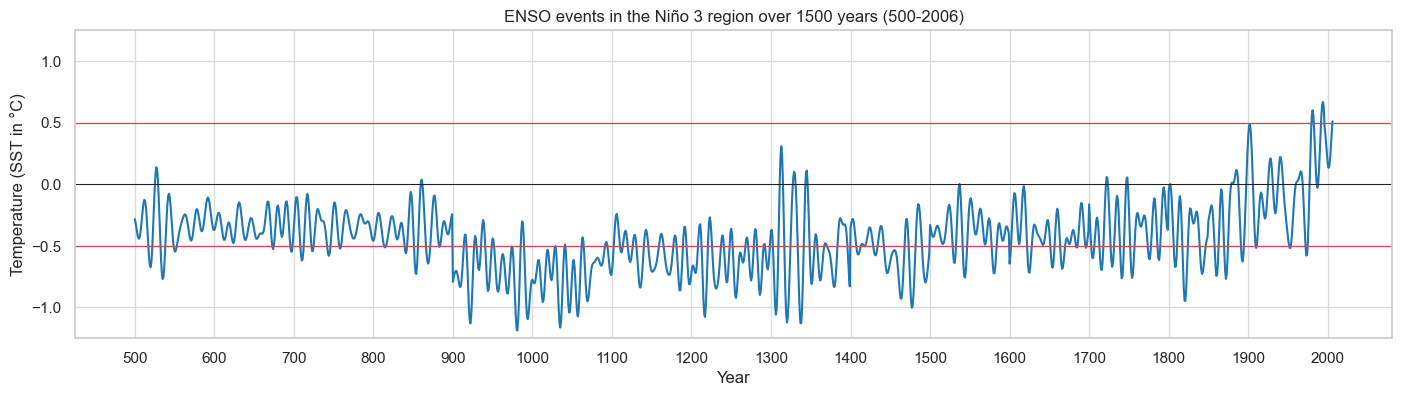

In [4]:
#Plotting a line plot for the 'SST' column
plt.figure(figsize=(17,4))
plt.plot(dn['SST'], label='Temperature')
plt.title('ENSO events in the Niño 3 region over 1500 years (500-2006)')
plt.xlabel('Year')
plt.ylabel('Temperature (SST in °C)')
plt.axhline(y=0, color='k', linestyle='-', lw=0.7)
plt.axhline(y=0.5, color='r', linestyle='-', lw=0.9)
plt.axhline(y=-0.5, color='r', linestyle='-', lw=0.9)
plt.xticks(np.arange(500, 2006, step=100))
plt.ylim((-1.25, 1.25))
plt.grid(color = 'gainsboro')
plt.show()

The plot above shows the trend of the temperature over the years. It seems to follow a cyclic pattern with fluctuations.

/Users/neina/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

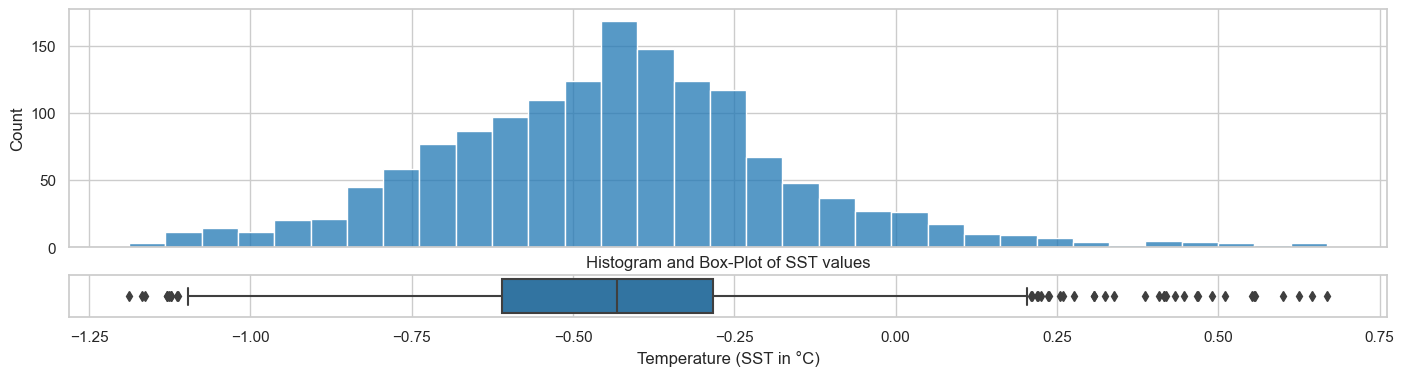

In [7]:
plt.figure(figsize=(10,4))
 
#Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, figsize=(17,4), gridspec_kw={"height_ratios": (.85, .15)})
plt.title('Histogram and Box-Plot of SST values')

#Assigning a graph to each ax
sns.boxplot(dn['SST'], ax=ax_box)
sns.histplot(data=dn, x="SST", ax=ax_hist)
 
#Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.xlabel('Temperature (SST in °C)')
plt.show()

- Histogram: The histogram shows the distribution of temperature values. Most of the values are centered around −0.434, with some spread on both sides. The data appears to be slightly skewed to the left.

- Box-Plot: The box-plot provides a visual representation of the spread of the data and helps identify any potential outliers. In this case, we don't see any significant outliers since we are working with the El Niño/La Niña thresholds.

### SEASONALITY ANALYSIS

Given the cyclic pattern observed in the previosu plot, let's decompose the time series to observe any underlying trend, seasonality, and residual components.

Let's quickly check for any missing values in the data set:

In [8]:
# Checking for missing values in the 'temp' column
missing_values_count = dn['SST'].isnull().sum()
missing_values_count

0

To understand the underlying patterns in the data, we decompose the time series into trend, seasonal, and residual components using seasonal decomposition of time series (STL). This will help us identify any regular patterns or cycles in the data.

In [9]:
# Importing seasonal decomposition
from statsmodels.tsa.seasonal import STL

# Decomposing the time series into trend, seasonal, and residual components
stl = STL(dn['SST'], seasonal=13)
result = stl.fit()

# Plotting the decomposition
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(result.trend)
plt.title('Trend Component')
plt.xlabel('Year')
plt.ylabel('Temperature')

plt.subplot(3, 1, 2)
plt.plot(result.seasonal)
plt.title('Seasonal Component')
plt.xlabel('Year')
plt.ylabel('Temperature')

plt.subplot(3, 1, 3)
plt.plot(result.resid)
plt.title('Residual Component')
plt.xlabel('Year')
plt.ylabel('Temperature')

plt.tight_layout()
plt.show()

ValueError: Unable to determine period from endog

It appears that the error occurred because the STL decomposition was unable to automatically determine the seasonality period from the data. This is often the case when the seasonality pattern is not clearly defined or when the data doesn't have an explicit seasonal cycle. We perform other analyses to understand the data better, such as checking for stationarity or autocorrelation.

1. Stationarity Test: We perform the *Augmented Dickey-Fuller (ADF)* test to check if the time series is stationary. A stationary time series has constant mean, variance, and autocorrelation over time.

2. Autocorrelation Analysis: We plot the *Autocorrelation Function (ACF)* and *Partial Autocorrelation Function (PACF)* to understand how the data is correlated with its lagged values.

### STATIONARITY TEST

In [10]:
# Importing the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

# Performing the ADF test on the 'temp' column
adf_result = adfuller(dn['SST'])

# Extracting the test statistic and p-value
adf_statistic = adf_result[0]
adf_pvalue = adf_result[1]

adf_statistic, adf_pvalue

(-1.0109714833912278, 0.7492417005383631)

The Augmented Dickey-Fuller (ADF) test provides the following results:

- Test Statistic: −1.011
- P-value: 0.749

A p-value greater than 0.05 (in this case, 0.749) indicates that we fail to reject the null hypothesis. This suggests that the time series is non-stationary.

### AUTOCORRELATION ANALYSIS

Now we plot the ACF and PACF to understand how the temperature values are correlated with their lagged values. This can provide insights into the underlying patterns and relationships within the time series.

<Figure size 1000x400 with 0 Axes>

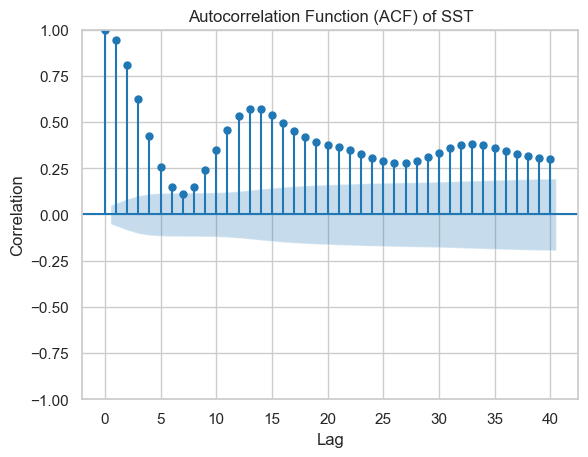

/Users/neina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

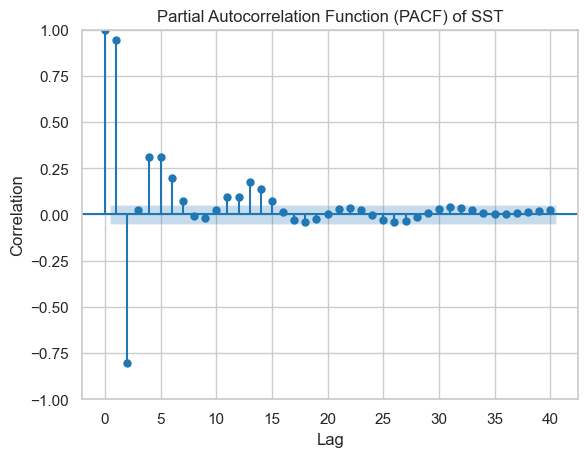

In [11]:
# Importing the autocorrelation function and partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the ACF
plt.figure(figsize=(10,4))
plot_acf(dn['SST'], lags=40)
plt.title('Autocorrelation Function (ACF) of SST')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Plotting the PACF
plt.figure(figsize=(10, 6))
plot_pacf(dn['SST'], lags=40)
plt.title('Partial Autocorrelation Function (PACF) of SST')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

- The ACF plot shows how the temperature values are correlated with their previous values at different lags. A gradual decline in the ACF plot suggests a slow decay in correlation, which is often associated with non-stationary time series.

- The PACF plot reveals the correlation between the time series and its lags after accounting for the correlations of intervening lags. The spikes at specific lags might indicate potential autoregressive terms if we were to fit a time series model to this data.

### SUMMARY OF THE EDA

1. The data consists of 1506 temperature observations (from 500 to 2006).
2. The mean temperature is approximately −0.434, and the data is slightly skewed to the left.
3. The time series appears to be non-stationary, as indicated by the ADF test.

---

### TIME SERIES ANALYSIS FOR TIME-DELAY EMBEDDING

Autocorrelation and Time-Delay Embeddings (TDE) are both concepts related to time series analysis, and they share a connection in understanding the underlying dynamics of a system.

#### Time Delay Embeddings

TDE are a technique used to reconstruct a multidimensional phase space from a time series. This reconstruction is based on "Takens' Embedding Theorem", and it provides a geometrical representation of the dynamical system's behavior.

The process involves creating vectors from the original time series by considering the value at a given time, the value at a time delay later, the value at two time delays later, and so on. The choice of time delay (k) and the number of dimensions (m) is crucial.

In the case of the Nino3 time series, this embedding can help us understand the underlying dynamics of the ENSO phenomenon. For this analysis, we select k and m through two packages: NoLitSA and giotto-tda:

### FINDING OPTIMAL EMBEDDING PARAMETERS

In [18]:
y = dn.values.squeeze()

def find_optimal_delay(x, maxtau=20):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)
    return np.where(diffmi > 0)[0][0]

def find_optional_dimension(x, tau, max_dim=10):
    dim = np.arange(1, max_dim)
    f1, f2, f3 = dimension.fnn(x, tau=tau, dim=dim)
    return np.where(f1 < 0.2)[0][0] + 1

def manual_optimal_parameters(x):
    d = find_optimal_delay(x)
    m = find_optional_dimension(x, tau=d)
    print((d, m))

In [19]:
# Using NoLitSA to find optimal embedding parameters (k and m)
manual_optimal_parameters(y)

(5, 3)


5

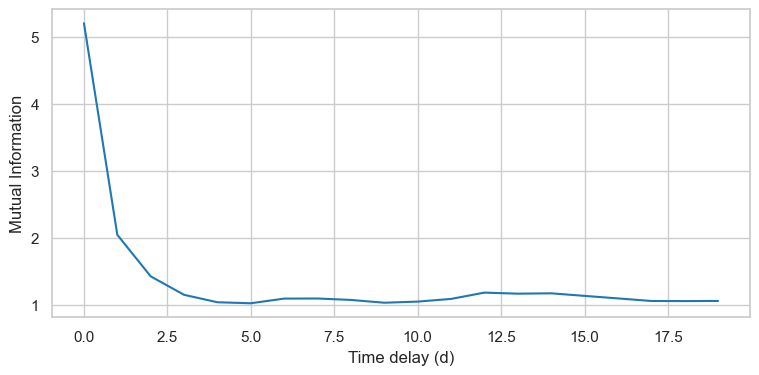

In [22]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (d)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(y, maxtau=20))

def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)
    return np.where(diffmi > 0)[0][0]

find_optimal_delay(y)

As we can see, the first local minima seems to be located on the time delay d = 5

3

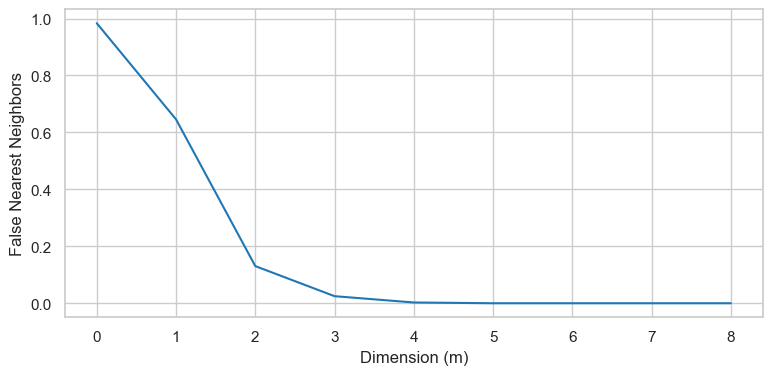

In [23]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(y, tau=4, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (m)')
plt.ylabel('False Nearest Neighbors')
plt.plot(f1)

def find_optional_dimension(x, tau, max_dim=10):
    dim = np.arange(1, max_dim)
    f1, f2, f3 = dimension.fnn(x, tau=tau, dim=dim)
    return np.where(f1 < 0.2)[0][0] + 1

find_optional_dimension(y, 4)

As we can see, for two dimensions the FNN go below 20%, therefore m = 2

In [21]:
# Using giotto-tda to find optimal embedding parameters (k and m)
STE = SingleTakensEmbedding(parameters_type='search', dimension=3, time_delay=5, n_jobs=-1)

# Fit and transform
signal_embedded = STE.fit_transform(y)

print('Optimal time delay based on mutual information:', STE.time_delay_)

print('Optimal embedding dimension based on false nearest neighbors:', STE.dimension_)

Optimal time delay based on mutual information: 4
Optimal embedding dimension based on false nearest neighbors: 2


### PLOT THE TIME-DELAY EMBEDDING

Let's proceed with the 2D delay embedding using the chosen value of k:

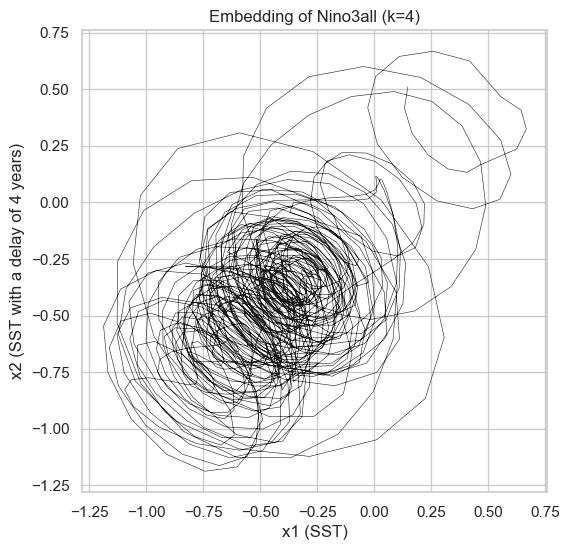

In [12]:
# Defining k for delay-embedding
k = 4

# Creating the 2D embedding using delay
dn['x1'] = dn['SST']
dn['x2'] = dn['SST'].shift(-k)

# Dropping NaN values that may result from the shift
dn.dropna(inplace=True)

# Plotting the 2D embedding
plt.figure(figsize=(6,6))
plt.plot(dn['x1'], dn['x2'], 'k-', lw=0.4)
plt.xlabel('x1 (SST)')
plt.ylabel('x2 (SST with a delay of 4 years)')
plt.title('Embedding of Nino3all (k=4)')
plt.show()

The TDE provide a geometrical representation of the dynamical system's behavior using the chosen time delays k=4 repectively.

In this plot:
- The x-axis represents the temperature at time t.
- The y-axis represents the temperature at time t+k, where k is the chosen time delay.

Now, let's delve into the analysis of the plot and discuss some aspects of the system's behavior:

#### 1. Structure of the System
The TDE provides a reconstruction of the system's phase space based on sea surface temperature. This reconstruction preserves the topological properties of the system, allowing us to analyze its structure:

- **Continuity:** The plot show a continuous trajectory, indicating that the system's dynamics are deterministic and not random.
- **Complexity:** The twisting and looping patterns in the plot suggest a complex and nonlinear relationship within the system. It may hint at underlying cycles or oscillations.


#### 2. Trajectory Shape: Stability, Periodicity, or Chaos
The shape of the trajectory provides insights into the underlying dynamics of the system:

- **Stability:** If the trajectory was converging to a single point or a stable limit cycle, it would indicate stability within the system. In this plot, we don't see clear evidence of convergence to a single point, so the system does not appear to be stable in that sense.
- **Periodicity:** The repeated looping patterns in the trajectory suggest the presence of periodic behavior or oscillations. This may be indicative of a recurring pattern in temperature, such as El Nino/La Nina cycles.
- **Chaos:** While the plot shows complexity, it doesn't exhibit a highly tangled or erratic pattern that would typically indicate chaotic behavior. The presence of clear loops suggests some order in the system's dynamics.

**Next questions: How can these plots explain ENSO's behaviour? How can sonification help us understand them better?**

Sonification can be used to understand the underlying patterns of a time delay embedding. It allows us to listen to the trajectory of the system, turning the spatial arrangement of points in the embedding into an auditory representation. This auditory representation can help clarify patterns, cycles, and start and convergence points that may not be immediately apparent from visual inspection of the embedding (Go to the Jupyter Notebook "Nino3_WSS").